In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [2]:
from models.code_models import torch_models

test_dataset = torch.load(r"C:\Users\iqbal\Desktop\4º Carrera\Proyecto En DS\DS-HPE\data\interm\test_dataset.pt")

C:\Users\iqbal\AppData\Local\Temp\ipykernel_4768\788640587.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_dataset = torch.load(r"C:\Users\iqbal\Desktop\4º Carrera\

In [3]:
X_test_tensor = test_dataset.tensors[0]
y_test = test_dataset.tensors[1]

In [4]:
input_dim = X_test_tensor.shape[1]
model =  torch_models.DeepMLP(input_dim=input_dim)

model.load_state_dict(torch.load(r'C:\Users\iqbal\Desktop\4º Carrera\Proyecto En DS\DS-HPE\models\trained_models\model.pt'))
model.eval()

y_true = y_test  # Your actual test values
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()
    y_true = y_true.cpu().numpy()

C:\Users\iqbal\AppData\Local\Temp\ipykernel_4768\2837611866.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r'C:\Users\iqbal\Desktop\4º 

## 2. Calculate Comprehensive Metrics

In [8]:
def calculate_all_metrics(y_true, y_pred, target_names=['Mean Power', 'Min Power', 'Max Power']):

    metrics = []
    
    for i, name in enumerate(target_names):
        y_t = y_true[:, i]
        y_p = y_pred[:, i]
        
        mae = mean_absolute_error(y_t, y_p)
        rmse = np.sqrt(mean_squared_error(y_t, y_p))
        mse = mean_squared_error(y_t, y_p)
        r2 = r2_score(y_t, y_p)
        
        min_error = np.min(np.abs(y_t - y_p))
        max_error = np.max(np.abs(y_t - y_p))
        
        # Calculate what percentage of predictions are within certain thresholds
        errors = np.abs(y_t - y_p)
        within_5_pct = np.mean(errors <= np.mean(y_t) * 0.05) * 100
        within_10_pct = np.mean(errors <= np.mean(y_t) * 0.10) * 100
        within_20_pct = np.mean(errors <= np.mean(y_t) * 0.20) * 100
        
        metrics.append({
            'Target': name,
            'MAE': mae,
            'RMSE': rmse,
            'MSE': mse,
            'R²': r2,
            'Min Error': min_error,
            'Max Error': max_error,
            'Within 5%': within_5_pct,
            'Within 10%': within_10_pct,
            'Within 20%': within_20_pct,
            'Avg True Value': np.mean(y_t),
            'Avg Predicted': np.mean(y_p)
        })
    
    return pd.DataFrame(metrics)

metrics_df = calculate_all_metrics(y_true, y_pred)
print(metrics_df.to_string(index=False))

    Target        MAE       RMSE          MSE       R²  Min Error   Max Error  Within 5%  Within 10%  Within 20%  Avg True Value  Avg Predicted
Mean Power 119.696663 166.160202 27609.212891 0.276799   0.008301 1245.024902  24.416191   42.169751   69.515078      729.061707     714.331177
 Min Power 117.110397 168.552444 28409.925781 0.267853   0.002686 1201.695435  22.372139   40.019028   69.131638      642.722473     626.639465
 Max Power 164.458389 225.567200 50880.562500 0.305724   0.000610 1253.113281  20.970997   36.516174   60.367295      816.522522     802.330811


## Error Distribution Analysis

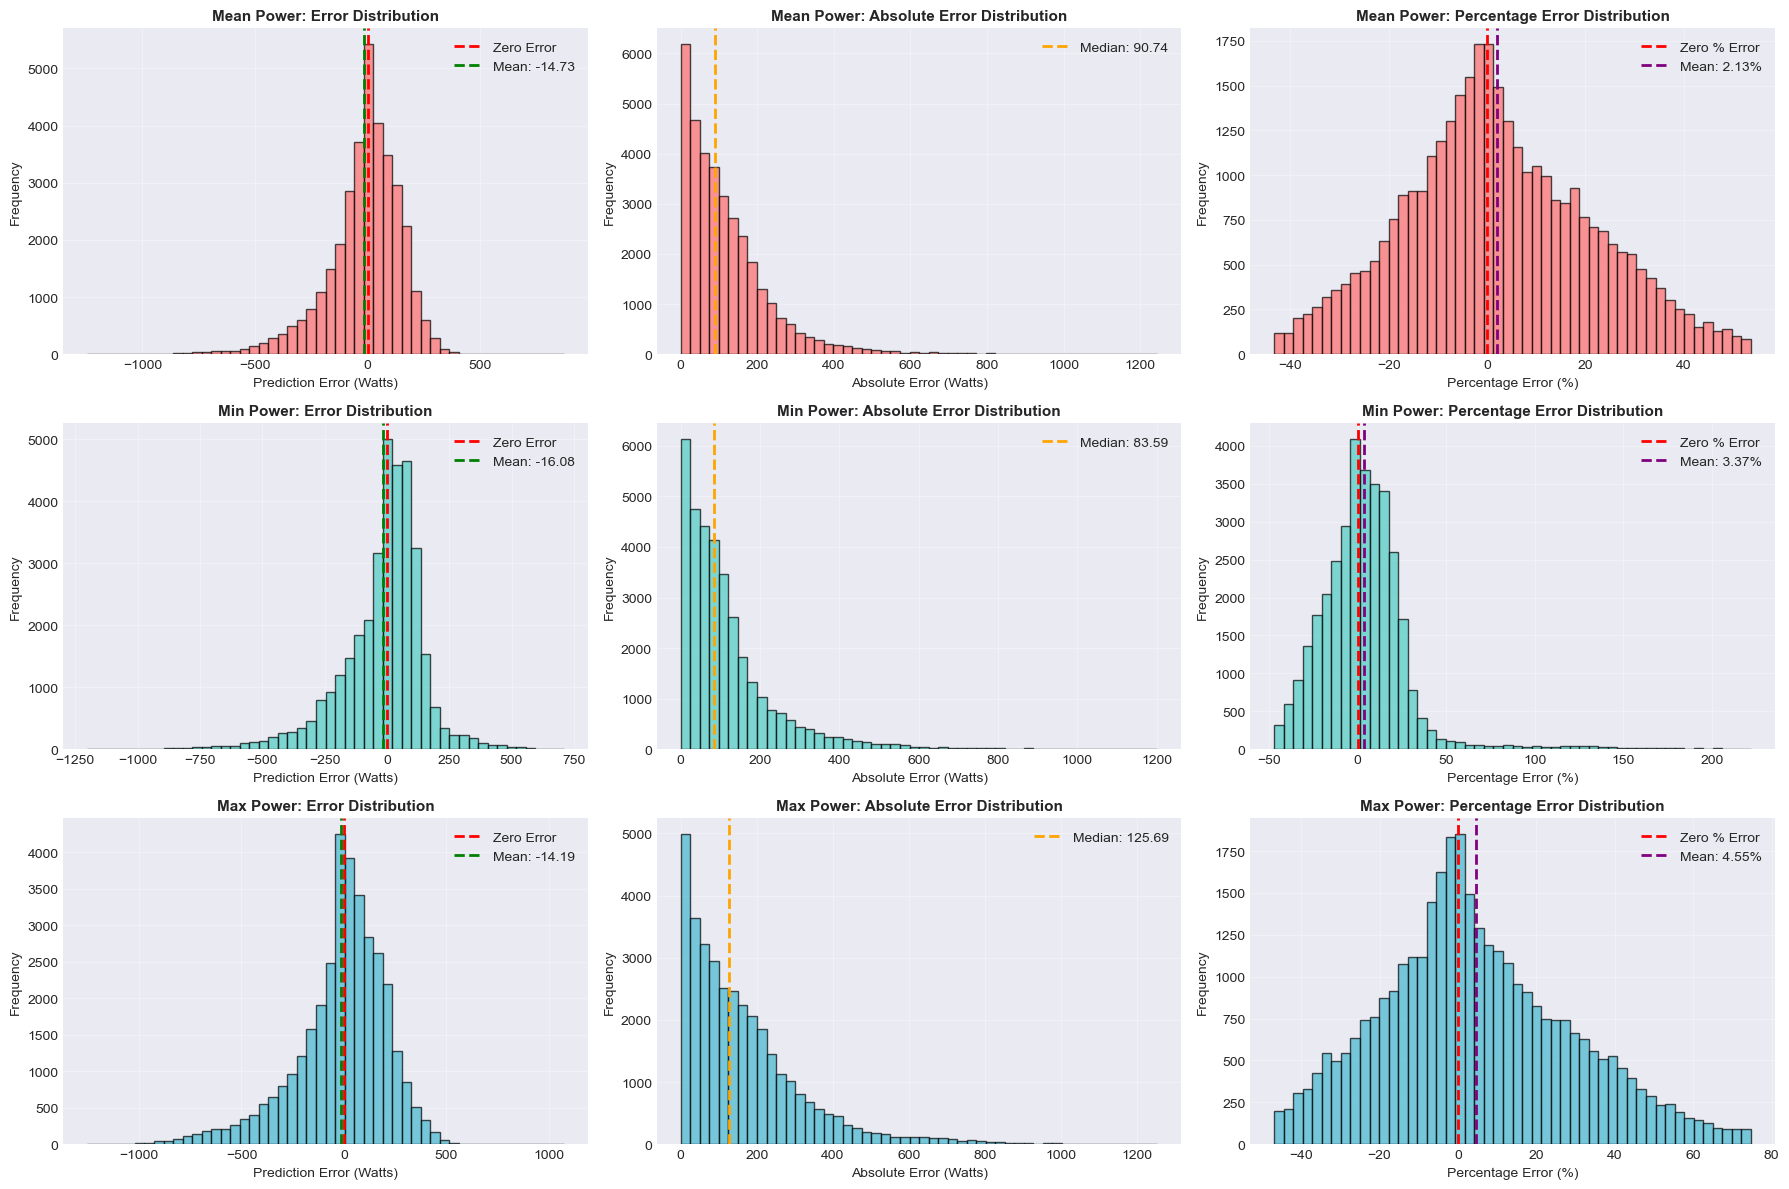

In [24]:
def plot_error_distributions(y_true, y_pred, target_names=['Mean Power', 'Min Power', 'Max Power']):
    """
    Visualize the distribution of prediction errors, absolute errors,
    and percentage errors.
    """
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for i, name in enumerate(target_names):
        errors = y_pred[:, i] - y_true[:, i]
        abs_errors = np.abs(errors)
        pct_errors = (errors / y_true[:, i]) * 100

        low, high = np.percentile(pct_errors, [1, 99])
        pct_errors = pct_errors[(pct_errors >= low) & (pct_errors <= high)]


        # 1. Error Distribution
        ax1 = axes[i, 0]
        ax1.hist(errors, bins=50, color=colors[i], alpha=0.7, edgecolor='black')
        ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
        ax1.axvline(
            x=np.mean(errors), color='green', linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(errors):.2f}'
        )
        ax1.set_xlabel('Prediction Error (Watts)', fontsize=10)
        ax1.set_ylabel('Frequency', fontsize=10)
        ax1.set_title(f'{name}: Error Distribution', fontsize=11, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Absolute Error Distribution
        ax2 = axes[i, 1]
        ax2.hist(abs_errors, bins=50, color=colors[i], alpha=0.7, edgecolor='black')
        ax2.axvline(
            x=np.median(abs_errors), color='orange', linestyle='--', linewidth=2,
            label=f'Median: {np.median(abs_errors):.2f}'
        )
        ax2.set_xlabel('Absolute Error (Watts)', fontsize=10)
        ax2.set_ylabel('Frequency', fontsize=10)
        ax2.set_title(f'{name}: Absolute Error Distribution', fontsize=11, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. Percentage Error Distribution
        ax3 = axes[i, 2]
        ax3.hist(pct_errors, bins=50, color=colors[i], alpha=0.7, edgecolor='black')
        ax3.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero % Error')
        ax3.axvline(
            x=np.mean(pct_errors), color='purple', linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(pct_errors):.2f}%'
        )
        ax3.set_xlabel('Percentage Error (%)', fontsize=10)
        ax3.set_ylabel('Frequency', fontsize=10)
        ax3.set_title(f'{name}: Percentage Error Distribution', fontsize=11, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_error_distributions(y_true, y_pred)